In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import random
import sys
from tqdm import tqdm
sys.path.append('../visualization')
sys.path.append('../dsets/mnist')

import viz_2d as viz
import acd
import dset
from model import Net

# load the model and dset

In [2]:
# load the dataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'
im_torch, im_orig, label = dset.get_im_and_label(250, device=device) # this will download the mnist dataset


# load the model
model = Net().to(device)
model.load_state_dict(torch.load('../dsets/mnist/mnist.model', map_location=device))
model = model.eval()

# simple mnist examples

0it [00:00, ?it/s]/accounts/projects/vision/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/accounts/projects/vision/.local/lib/python3.8/site-packages/acd/scores/score_funcs.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(model(input_vecs))[:, class_to_explain]
4it [00:41, 10.43s/it]


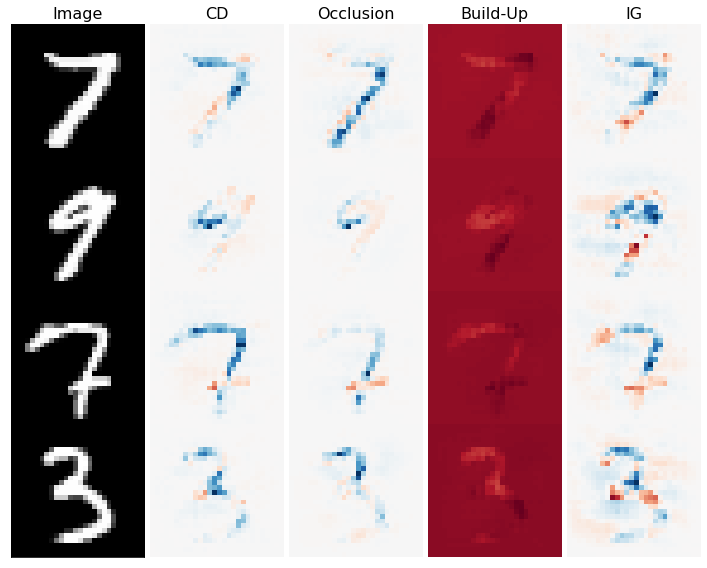

In [ ]:
def get_diff_scores(im_torch, im_orig, label_num, model, preds, sweep_dim):
    '''Computes different attribution scores
    '''
    scores = []

    # cd
    method = 'cd'
    tiles = acd.tiling_2d.gen_tiles(im_orig, fill=0, method=method, sweep_dim=sweep_dim)
    scores_cd = acd.get_scores_2d(model, method=method, ims=tiles, 
                                   im_torch=im_torch, model_type=model_type, device=device)
    scores.append(scores_cd)
    for method in ['occlusion', 'build_up']: # 'build_up'
        tiles_break = acd.tiling_2d.gen_tiles(im_orig, fill=0, method=method, sweep_dim=sweep_dim)
        preds_break = acd.get_scores_2d(model, method=method, ims=tiles_break, 
                                            im_torch=im_torch, pred_ims=dset.pred_ims)
        if method == 'occlusion':
            preds_break += preds
        scores.append(np.copy(preds_break))
    
    # get integrated gradients scores
    scores.append(acd.ig_scores_2d(model, im_torch, num_classes=10, 
                                           im_size=28, sweep_dim=sweep_dim, ind=[label_num], device=device))
    return scores



# pick an image + get scores
im_nums = [34, 20, 36, 32] # 34: screen, 20: snake, 36: trash can, 32: crane
sweep_dim = 1
model_type = 'mnist'
# sweep_dim = 56
fig = plt.figure(figsize=(10, 8), facecolor='white')

for x, im_num in tqdm(enumerate(im_nums)):

    im_torch, im_orig, label_num = dset.get_im_and_label(im_num, device=device) # this will download the mnist dataset
    preds = dset.pred_ims(model, im_orig, device=device).flatten()
    ind = np.argpartition(preds, -8)[-8:] # top-scoring indexes
    ind = ind[np.argsort(preds[ind])][::-1] # sort the indexes
    scores = get_diff_scores(im_torch, im_orig, label_num, model, preds, sweep_dim)

    # plot raw image
    num_rows = len(im_nums)
    num_cols = len(scores) + 1
    plt.subplot(num_rows, num_cols, 1 + x * num_cols)
    plt.imshow(im_orig, cmap='gray')
    plt.gca().xaxis.set_visible(False)
    plt.yticks([])
    if x == 0:
        plt.title('Image', fontsize=16)


    # plot scores
    vmax = max([np.max(scores[i]) for i in range(len(scores))])
    vmin = min([np.min(scores[i]) for i in range(len(scores))])
    vabs = max(abs(vmax), abs(vmin))
    for i, tit in enumerate(['CD', 'Occlusion', 'Build-Up', 'IG']):
        plt.subplot(num_rows, num_cols, 2 + i + x * num_cols)
        if i == 0:
            plt.ylabel('pred: ' + str(ind[0]) + '...', fontsize=15)     
        if x == 0:
            plt.title(tit, fontsize=16)
        p = viz.visualize_preds(scores[i], num=label_num, cbar=False) #axis_off=False,  vabs=vabs)
        plt.xticks([])
        plt.yticks([])
#     divider = make_axes_locatable(plt.gca())
#     cax = divider.append_axes("right", size="2%", pad=0.05)
#     plt.colorbar(p, cax=cax)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [3]:
def attack_im_num(dset, model, im_num, attack_type, device='cuda'):
    '''Return adversarially manipulated image
    '''
    # seed
    np.random.seed(13)
    random.seed(13)
    torch.manual_seed(13)
    
    im_torch, im_orig, label = dset.get_im_and_label(im_num, device=device)
    pix_min = np.min(im_torch.data.cpu().numpy())
    pix_max = np.max(im_torch.data.cpu().numpy())
    fmodel = foolbox.models.PyTorchModel(model, bounds=(pix_min-1, pix_max+1))
#     if attack_type == 'saliency':
#         attack = foolbox.attacks.SaliencyMapAttack() # saliency map attack has some good stuff
    if attack_type == 'fgsm':
        attack = foolbox.attacks.LinfFastGradientAttack() # saliency map attack has some good stuff
    elif attack_type == 'gradientattack':
        attack = foolbox.attacks.L2FastGradientAttack() # saliency map attack has some good stuff
    elif attack_type == 'deepfoolattack':
        attack = foolbox.attacks.L2DeepFoolAttack() # saliency map attack has some good stuff
    elif attack_type == 'boundaryattack':
        attack = foolbox.attacks.BoundaryAttack() # saliency map attack has some good stuff

    if attack_type == 'boundaryattack':
        _, im_orig_advs, success = attack(fmodel, im_torch,
                                          torch.LongTensor([label]).to(device), epsilons=[1.0]) #, log_every_n_steps=10000)
    else:
        _, im_orig_advs, success = attack(fmodel, im_torch,
                                          torch.LongTensor([label]).to(device), epsilons=[1.0])
    im_torch_adv = im_orig_advs[0]
    
    # # set up vars
    im_orig_adv = im_torch_adv.data.cpu().numpy()[0, 0] # make this 28 x 28
    
    # see preds
    pred_orig = model(im_torch).exp().data.cpu().numpy().flatten()
    pred_adv = model(im_torch_adv).exp().data.cpu().numpy().flatten()
    targets = np.argsort(pred_adv)
    target = targets[-1]
    if target == label:
        target = targets[-2]
    
    return im_orig, im_torch, im_orig_adv, im_torch_adv, label, target, pred_orig, pred_adv

# s4 - plot adversarial attacks

100%|██████████| 3/3 [00:00<00:00, 13.66it/s]


shapes (28, 28) (28, 28)
	label: 0 0.9999685 -> 0.060193013
	target: 2 1.7600636e-05 -> 0.47139338
shapes (28, 28) (28, 28)
	label: 0 0.9999685 -> 0.99989164
	target: 2 1.7600636e-05 -> 5.7216665e-05
shapes (28, 28) (28, 28)
	label: 0 0.9999685 -> 0.99991107
	target: 2 1.7600636e-05 -> 3.786103e-05


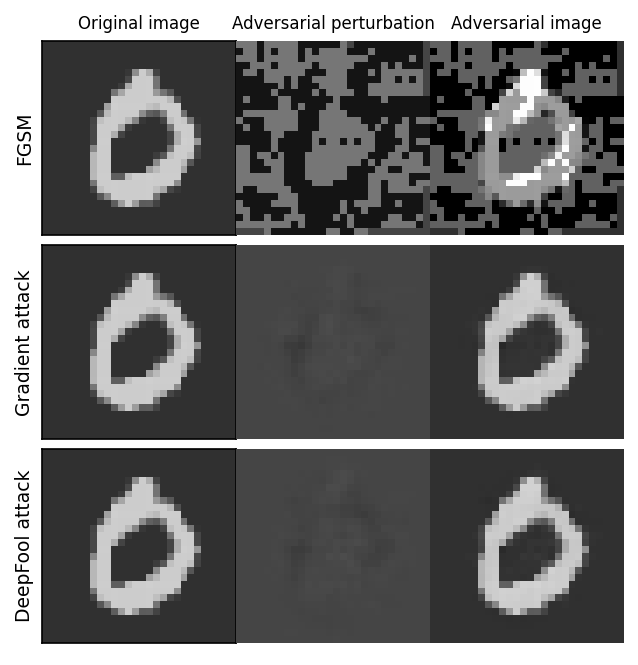

In [4]:
# attack image in several ways
im_num = 3
ats = ['fgsm', 'gradientattack', 'deepfoolattack'] #, 'boundaryattack']
vals = []
for attack_type in tqdm(ats):
    im_orig, im_torch, im_orig_adv, im_torch_adv, label, target, pred_orig, pred_adv = attack_im_num(dset, model, im_num, attack_type, device=device)
    vals.append((im_orig, im_torch, im_orig_adv, im_torch_adv, label, target, pred_orig, pred_adv))


plt.figure(figsize=(5, 9), dpi=150)
num_rows = 5
num_cols = 3
titsize = 8
labsize = 9
att_names = ['FGSM', 'Gradient attack', 'DeepFool attack', 'Boundary attack'] # 'Saliency attack', 

# find min and max
vmin = 1000
vmax = 0
for i, attack_type in enumerate(ats):
    (im_orig, im_torch, im_orig_adv, im_torch_adv, label, target, pred_orig, pred_adv) = vals[i]
    vmi = min([np.min(im) for im in [im_orig, im_orig_adv, im_orig - im_orig_adv]])
    vma = max([np.max(im) for im in [im_orig, im_orig_adv, im_orig - im_orig_adv]])
    vmin = min(vmi, vmin)
    vmax = max(vma, vmax)

# plot
for i, attack_type in enumerate(ats):
    (im_orig, im_torch, im_orig_adv, im_torch_adv, label, target, pred_orig, pred_adv) = vals[i]

    plt.subplot(num_rows, num_cols, num_cols * i + 1)
    plt.imshow(im_orig, cmap='gray', vmin=vmin, vmax=vmax)
    plt.gca().xaxis.set_visible(False)
    plt.gca().yaxis.set_ticks([])
    if i == 0:
        plt.title('Original image', fontsize=titsize)
    plt.ylabel(att_names[i], fontsize=labsize)

    plt.subplot(num_rows, num_cols, num_cols * i + 2)
    print('shapes', im_orig_adv.shape, im_orig.shape)
    plt.imshow(im_orig_adv - im_orig, cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    if i == 0:
        plt.title('Adversarial perturbation', fontsize=titsize)
        
    plt.subplot(num_rows, num_cols, num_cols * i + 3)
    plt.imshow(im_orig_adv, cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    if i == 0:
        plt.title('Adversarial image', fontsize=titsize)
    print('\tlabel:', label, pred_orig[label], '->', pred_adv[label])
    print('\ttarget:', target, pred_orig[target], '->', pred_adv[target])        

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# s3 - plot adv agg examples
Shows a lot of debugging information on scores and predictions for different classes

Original image


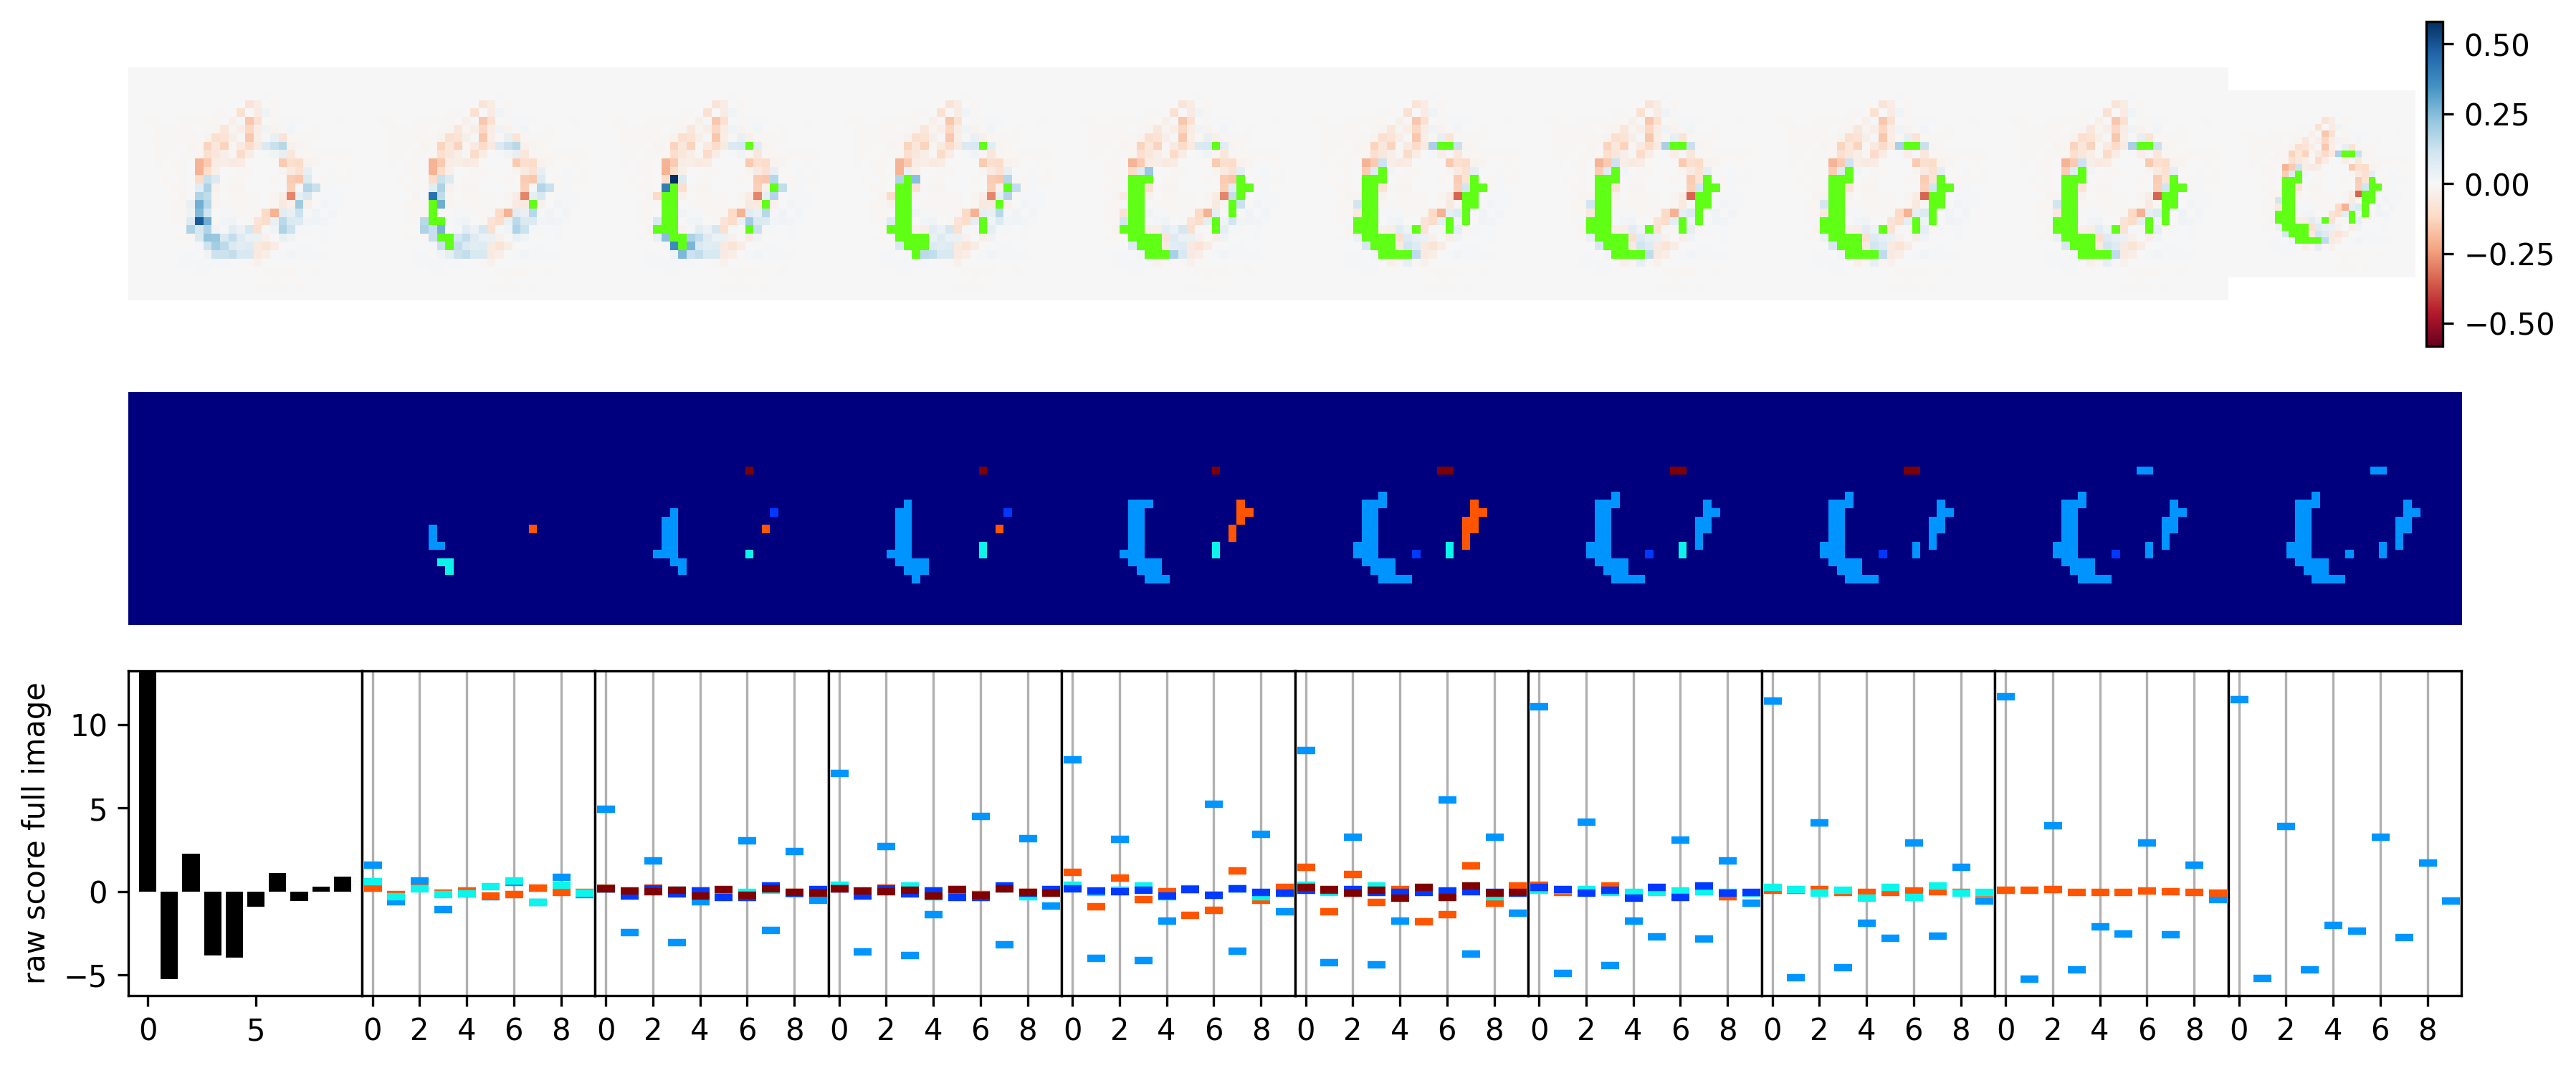

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [5]:
# agg params
method = 'cd'
percentile_include = 99
sweep_dim = 1
num_iters = 5
lists = acd.agg_2d.agglomerate(model, dset.pred_ims, percentile_include, 'cd', sweep_dim, im_orig, 
                        model.predicted_class(im_torch), num_iters=num_iters, im_torch=im_torch, 
                        model_type='mnist', device=device)


# image and attack
im_num = 3
attack_type = 'deepfoolattack'
im_orig, im_torch, im_orig_adv, im_torch_adv, label, target, pred_orig, pred_adv = attack_im_num(dset, model, im_num, attack_type)


        
# visualize original image
print('Original image')
rows=3
plt.figure(figsize=(14, 6), facecolor='white', dpi=300)
viz.visualize_ims_list(lists['scores_list'], 
                       cmap_new='redwhiteblue',
                       title='Refined scores',
                       subplot_row=0, subplot_rows=rows, colorbar=True)
viz.visualize_ims_list(lists['comps_list'],
                      title='blobs',
                      subplot_row=1, subplot_rows=rows, colorbar=False)
viz.visualize_dict_list(lists['comp_scores_raw_list'], method,
                       subplot_row=2, subplot_rows=rows)
plt.show()

lists = acd.agg_2d.agglomerate(model, dset.pred_ims, percentile_include, 
                method, sweep_dim, im_orig_adv, 
                model(im_torch), num_iters=num_iters, 
                im_torch=im_torch_adv, model_type='mnist', device=device)

# visualize adversarial image
print('Adversarial image')
rows=3
plt.figure(figsize=(14, 6), facecolor='white', dpi=300)
viz.visualize_ims_list(lists['scores_list'], 
                       cmap_new='redwhiteblue',
                       title='Refined scores',
                       subplot_row=0, subplot_rows=rows, colorbar=True)
viz.visualize_ims_list(lists['comps_list'],
                      title='blobs',
                      subplot_row=1, subplot_rows=rows, colorbar=False)
viz.visualize_dict_list(lists['comp_scores_raw_list'], method,
                       subplot_row=2, subplot_rows=rows)
plt.show()